In [ ]:
# Previsão de Risco dos atributos de um empréstimo por algoritmo de machine learning 
import numpy as np
import pandas as pd 
from copy import deepcopy
import random


from sklearn.preprocessing import LabelEncoder


import os

import warnings
warnings.filterwarnings('ignore')


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split


from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score

from collections import defaultdict
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv("Case.csv")

In [ ]:
df.head()

,idade,experiencia,tempo_endereco,renda,debito_renda,cred_deb,outros_debitos,mau
0,41,17,12,35.9,11.90,0.504108,3.767992,0
1,30,13,8,46.7,17.88,1.352694,6.997266,0
2,40,15,14,61.8,10.64,3.438997,3.136523,0
3,41,15,14,72.0,29.67,4.165668,17.196732,0
4,57,7,37,25.6,15.86,1.498199,2.561961,0


In [ ]:
# Reamostrando variáveis 
df_bal = deepcopy(df) # Please note the difference between shallow copy and deep copy in Python
df_bal.dropna(inplace=True) # Drop missing values


random.seed(1234)


count_class_0, count_class_1 = df_bal['mau'].value_counts()


df_class_0 = df_bal[df_bal['mau'] == 0]
df_class_1 = df_bal[df_bal['mau'] == 1]


df_class_1_over = df_class_1.sample(count_class_0, replace=True, random_state=1234)
df_bal = pd.concat([df_class_1_over, df_class_0], axis=0)

df_bal.reset_index(inplace = True)

In [ ]:
df_bal['mau'].value_counts()

1    3744
0    3744
Name: mau, dtype: int64

In [ ]:
df_bal.dtypes.value_counts()

int64      5
float64    4
dtype: int64

In [ ]:
# 
# Diferenciação entre variáveis numéricas e categóricas 
numerical = df_bal.apply(pd.Series.nunique, axis = 0)[df_bal.apply(pd.Series.nunique, axis = 0).values>10].index
categorical = df_bal.apply(pd.Series.nunique, axis = 0)[df_bal.apply(pd.Series.nunique, axis = 0).values<=10].index
numerical = [i for i in numerical if i != 'index']
categorical = [i for i in categorical if i != 'bad_loans']

In [ ]:
 df_bal.apply(pd.Series.nunique, axis = 0)[df_bal.apply(pd.Series.nunique, axis = 0).values<=10]

mau    2
dtype: int64

In [ ]:
numerical

['idade',
 'experiencia',
 'tempo_endereco',
 'renda',
 'debito_renda',
 'cred_deb',
 'outros_debitos']

In [ ]:
import seaborn as sns
sns.set(style="darkgrid")

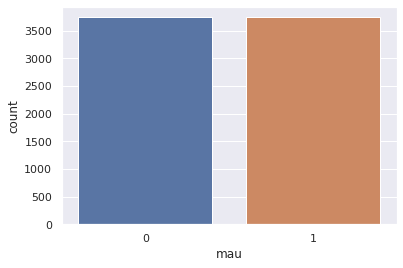

In [ ]:
#Frequência de variáveis categóricas 
for var in categorical:
    plt.figure()
    ax = sns.countplot(x=var, data=df_bal)

### Explorando variáveis 

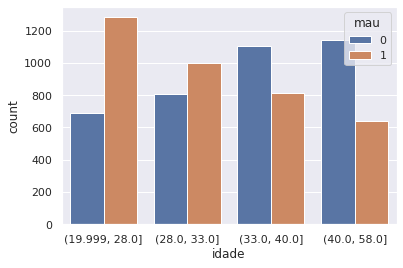

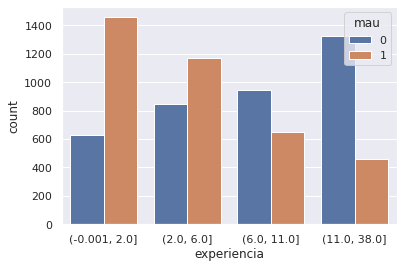

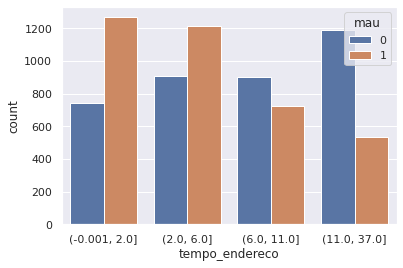

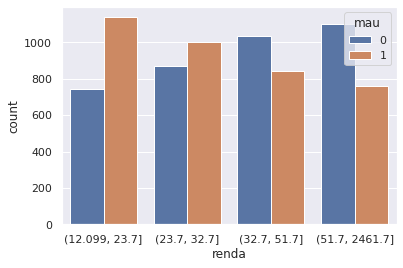

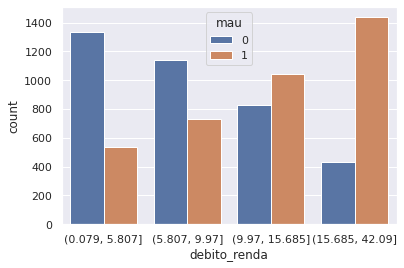

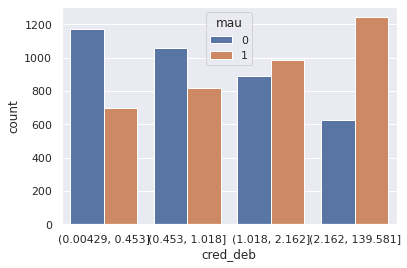

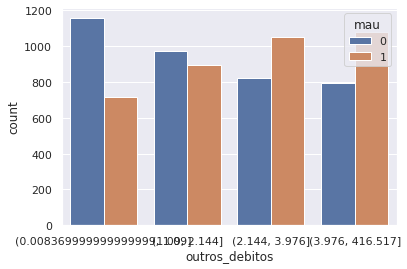

In [ ]:
quantile_list = [0,0.25,0.5,0.75,1]
#quantile_labels = ['0-25Q','25-50Q','50-75Q','75-100Q']
df_bin = pd.DataFrame()
df_bin['mau'] = df_bal['mau']
for var in numerical:
    df_bin[var]=pd.qcut(df_bal[var],q=quantile_list,duplicates='drop')
    plt.figure()
    ax = sns.countplot(x=var, hue='mau',data=df_bin)

## Seleção de variáveis



### 1) Teste chi2 

In [ ]:
import scipy.stats as stats
from scipy.stats import chi2_contingency

class ChiSquare:
    def __init__(self, dataframe):
        self.df = dataframe
        self.p = None #P-Value
        self.chi2 = None #Chi Test Statistic
        self.dof = None
        
        self.dfObserved = None
        self.dfExpected = None
        
    def _chisquare_result(self, colX, alpha):
        result = ""
        if self.p<alpha:
            result="{0} is IMPORTANT for Prediction".format(colX)
        else:
            result="{0} is NOT an important predictor. (Discard {0} from model)".format(colX)

        print(result)
        
    def TestIndependence(self,colX,colY, alpha=0.05):
        X = self.df[colX].astype(str)
        Y = self.df[colY].astype(str)
        
        self.dfObserved = pd.crosstab(Y,X) 
        chi2, p, dof, expected = stats.chi2_contingency(self.dfObserved.values)
        self.p = p
        self.chi2 = chi2
        self.dof = dof 
        
        self.dfExpected = pd.DataFrame(expected, columns=self.dfObserved.columns, index = self.dfObserved.index)
        if self.p<alpha:
            return True # accept variable
        else:
            return False

In [ ]:
accept_cT = []
reject_cT = []

In [ ]:
#Initialize ChiSquare Class
cT = ChiSquare(df_bal)

#Feature Selection
for var in categorical:
    status = cT.TestIndependence(colX=var,colY="mau")  
    if status:
        accept_cT.append(var)
    else:
        reject_cT.append(var)

In [ ]:
#Initialize ChiSquare Class
cT = ChiSquare(df_bin)

#Feature Selection
for var in numerical:
    status = cT.TestIndependence(colX=var,colY="mau")  
    if status:
        accept_cT.append(var)
    else:
        reject_cT.append(var)

In [ ]:
# Baseado no Chi quadrado a variável deve ser removida 
reject_cT

[]

In [ ]:
reject_ig

[]

Seleção de variável por random forest  from Random Forest Classifier

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

features = numerical + categorical
rf_sel = SelectFromModel(RandomForestClassifier(n_estimators = 100), threshold='median')
rf_sel.fit(df_bal[features], df_bal['mau'])

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False,

In [ ]:
random_forest_feat = df_bal[features].columns[rf_sel.get_support()]
print(len(random_forest_feat))
print(random_forest_feat)

4
Index(['experiencia', 'debito_renda', 'cred_deb', 'mau'], dtype='object')


### 4) Seleção de variáveis utilizando  Gradient Boosting Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb_sel = SelectFromModel(GradientBoostingClassifier(n_estimators = 100), threshold='median')
gb_sel.fit(df_bal[features], df_bal['mau'])
gradient_boost_feat = df_bal[features].columns[gb_sel.get_support()]
print(len(gradient_boost_feat))
print(gradient_boost_feat)

8
Index(['idade', 'experiencia', 'tempo_endereco', 'renda', 'debito_renda',
       'cred_deb', 'outros_debitos', 'mau'],
      dtype='object')


In [ ]:
correlation = []
infogain = []
randomforest_select = []
gradientboost_select = []
finalselection = pd.DataFrame()
for var in features:
    correlation.append(int(var in accept_cT))
    infogain.append(int(var in accept_ig))
    randomforest_select.append(int(var in random_forest_feat))
    gradientboost_select.append(int(var in gradient_boost_feat))

finalselection['variable'] = features
finalselection['correlation'] = correlation
finalselection['infogain'] = infogain
finalselection['randomforest_select'] = randomforest_select
finalselection['gradientboost_select'] = gradientboost_select
finalselection['sum'] = finalselection['correlation']+finalselection['infogain']+finalselection['randomforest_select']+finalselection['gradientboost_select']
finalselection['choice'] = finalselection['sum'] >= 2

In [ ]:
finalselection.head(10)

,variable,correlation,infogain,randomforest_select,gradientboost_select,sum,choice
0,idade,1,0,0,1,2,True
1,experiencia,1,0,1,1,3,True
2,tempo_endereco,1,0,0,1,2,True
3,renda,1,0,0,1,2,True
4,debito_renda,1,0,1,1,3,True
5,cred_deb,1,0,1,1,3,True
6,outros_debitos,1,0,0,1,2,True
7,mau,1,0,1,1,3,True


In [ ]:
reduced_features =finalselection['variable'][finalselection['choice'] == True].values
print(len(reduced_features))
reduced_features

8


array(['idade', 'experiencia', 'tempo_endereco', 'renda', 'debito_renda',
       'cred_deb', 'outros_debitos', 'mau'], dtype=object)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
scaler = MinMaxScaler(feature_range=[0, 1])
reduced_features2_rescaled = scaler.fit_transform(df_bal[reduced_features2])

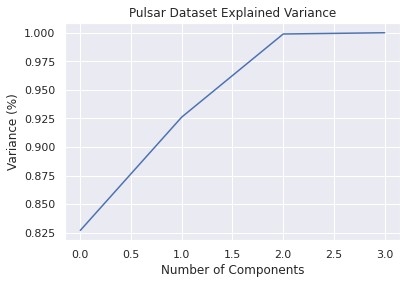

In [ ]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(reduced_features2_rescaled)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

#### Selecionar 20 componentes que correspondem a aproximadamente 100% dos dados

## Otimização
Valores de KS, ROC

In [ ]:
X = df
y = df_bal['mau']

In [ ]:
## Scoring functions ##
 
from sklearn.metrics import confusion_matrix
def scoring(X,y,y_test,y_pred, y_pred_prob, model):
    tn,fp,fn,tp=confusion_matrix(y_test,y_pred).ravel()
    print('True positive is ', tp)
    print('True negative is ', tn)
    print('False positive is ', fp)
    print('False negative is ', fn)
    
    accuracy = cross_val_score(model, X, y, cv = 5, scoring='accuracy').mean()
    f1 = cross_val_score(model, X, y, cv = 5, scoring='f1').mean()
    precision = cross_val_score(model, X, y, cv = 5, scoring='precision').mean()
    recall = cross_val_score(model, X, y, cv = 5, scoring='recall').mean()
    roc_auc = cross_val_score(model, X, y, cv = 5, scoring='roc_auc').mean()
    
    print('Cross validation mean accuracy is ', accuracy)
    print('Cross validation mean f1 is ', f1)
    print('Cross validation mean precision is ', precision)
    print('Cross validation mean recall is ', recall)
    print('Cross validation mean roc_auc is ', roc_auc)
    
    y_prob = y_pred_prob[:,1]
    data = {'y':list(y_pred), 'p':list(y_prob)}
    out = pd.DataFrame(data)
    ks_score_test = ks(data=out, target ='y', prob ='p')
    
def ks(data=None,target=None, prob=None):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob], 10, duplicates='drop')
    grouped = data.groupby('bucket', as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events']   = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 3) * 100

    #Formating
    kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    #kstable.index = range(1,11)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 9)
    print(kstable)
    
    #Display KS
    print(Fore.RED + "KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    return(kstable)